In [29]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function

from sklearn.cluster import DBSCAN
from sklearn import metrics

from random import randint
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist

import time
import sys
import h5py

from math import pow
from math import ceil

from numba import jit

from numpy import linalg as LA


# function 
# function 
def sex (labels,labels2):
    
    npo = len(labels)
        
    #aux label matrices    
    newlabels = np.zeros(npo,dtype=int) -2
    labels11 = np.zeros(npo,dtype=int)
    labels22 = np.zeros(npo,dtype=int)
    
    labels11[:] = labels
    labels22[:] = labels2
    

    # list of 1st points
    m1 = max(labels)
    jta = np.arange(0,npo,dtype=int)

    po1 = []
    for j in set(labels):
        if j > -1:
            parla1 = (labels  == j)
            po1.append(jta[parla1][0])
    po1 = np.array(po1)

    # list of 1st points
    m2 = max(labels2)

#     po2 = []
#     for j in range(0,m2):
#         parla2 = (labels2  == j)
#         po2.append(jta[parla2][0])
#     po2 = np.array(po2)
    
    # NOISE intersection
    parla1 = (labels  == -1)
    parla2 = (labels2 == -1)

    newlabels[parla1*parla2]   = -1
    labels11[parla1*parla2] = -2
    labels22[parla1*parla2] = -2

    dicta = []    
    # clusters UNION
    for i in set(labels): 
        if i > -1:
            # reference point
            posi = po1[i]
            ll = labels[posi]
            
            # all the neightbours of my point in the two labeling systems
            parla1 = (labels  == ll)
            parla2 = (labels2 == labels2[posi])
            
    #       print(ll,labels[posi],labels2[posi],len(labels[parla1]),len(labels2[parla2]))
    
            # if the point labels two clusters, group them
            if labels2[posi] > -1 :
                mask = np.logical_or(parla1,parla2)
                # some of the points in mask could be already assotiated to a cluster x 
                # actually different points could be assotiated to different clusters x0, x1, etc...
                # all these clusters are thus the same
                # set of newlabels in mask
                seta = np.array(list(set(newlabels[mask])))
                # set of mc labels
                seta = seta[seta > -1]
                
                if len(seta) > 1:
                    for lset in seta:
                        minimask = (newlabels == lset)
                        mask = np.logical_or(mask,minimask)
                    ll = min(seta)
                    #print(labels[posi], ' ojo ',seta, 'in newlabels assotiated to label',ll)                    
                    
                newlabels[mask] = ll
                labels11[mask] = -2
                labels22[mask] = -2
                
            # if the point labels noise [do not take all the noise!]
            elif labels2[posi] == -1 :
                mask = parla1 
                newlabels[mask] = ll
                labels11[mask] = -2

            dicta.append([labels[posi],labels2[posi]])
        
            
    maxrelab = max(newlabels)
    
    # list of labels of clusters in 2, which are noise in 1
    # 
    rela2 = np.array(list(set(labels22)))
    # oldstuff 
    # add them to newlabels
    # remove them from labels_aux
#     counter = 0 
#     for j in rela2:
#         if j > -1 :        
#             parla22 = (labels22  == j)

#             ll2 = j

#             newlabels[parla22] = maxrelab + counter
#             dicta.append([-1,ll2])
#             counter += 1

#             labels11[parla22] = -2
#             labels22[parla22] = -2    
    # however 
    counter = 0
    
    #print('rela2',rela2)
    for j in rela2:
        if j > -1 :        
            parla22 = (labels22  == j)
            # must anypoint of this MC need be asssotiated with a mc already present in newlabels?
            asolabel = np.array(list(set(labels2[parla22])))
            print(j, asolabel)
            asolabel = asolabel[asolabel > -1]

            ll2 = j
            
            if asolabel == []:    
                newlabels[parla22] = maxrelab + counter
                counter +=1 
                dicta.append([-1,ll2])
            elif len(asolabel) > 0:
                lala = min(asolabel)

                for l in asolabel:
                    para = (newlabels == l)
                    newlabels[para] = lala
                    dicta.append([lala,j])
                newlabels[parla22] = lala
                
            labels11[parla22] = -2
            labels22[parla22] = -2    


#     if len(labels[labels11 != -2])>0:
#         print('warning1',labels[labels11 != -2])
#     if len(labels[labels11 != -2])>0:    
#         print('warning2',labels2[labels22 != -2])
#         print('continue with l2')
                
    return newlabels, list(dicta)

# basicstuff
def basicstuff(data, dens_th) : 
    
    mask = ( data > dens_th)
    
    bas = np.zeros((n,n,n),dtype=float)
    linap = np.arange(0,n,dtype=float).reshape((n,1,1))
    x_pos = bas + linap
    y_pos = bas + linap.reshape((1,n,1))
    z_pos = bas + linap.reshape((1,1,n))
    del bas, linap
    x_pos = np.reshape(x_pos,(n3,))
    y_pos = np.reshape(y_pos,(n3,))
    z_pos = np.reshape(z_pos,(n3,))

    # position np.array
    npo = len(x_pos[mask])
    pos = np.empty((npo,3))
    pos[:,0] = x_pos[mask]
    pos[:,1] = y_pos[mask]
    pos[:,2] = z_pos[mask]

    den = data[mask]
    maxi = max(den)
    
    fractionofmass = np.add.reduce(den)/n3
    print('returned %d points containing %.1f/100 of the mass'%(npo,100*fractionofmass))
    return npo, pos, den, fractionofmass

## RELABEL ACCORDING TO MASS -> masslabels
## RELABEL ACCORDING TO #POINTS -> numblabels

def getMass(it):
    return it[1]

def getNumb(it):
    return it[2]

def relabelMN(newlabels,den):
    
    minilabels = np.array(list(set(newlabels)))

    poso = []

    #cocha = np.empty_like(minilabels)
    for l in minilabels:
        if l > -1:
            class_member_mask = (newlabels == l)
            poso.append( [l ,np.add.reduce(den[class_member_mask]), np.add.reduce(class_member_mask)] )
    # mass = <avdensity> (delta=sizeL/n)^3
    # cube = (sizeL/n)**3

    oroM = sorted(poso,key=getMass)
    oroN = sorted(poso,key=getNumb)

    numberoflabels = len(oroM)

    # relabel 
    masslabels = np.empty_like(newlabels)
    numblabels = np.empty_like(newlabels)

    # noise 

    masslabels[:] = newlabels[:]
    numblabels[:] = newlabels[:]

    
    counter = 0 

    for i in range(0,numberoflabels):
        para = (newlabels == oroM[i][0])
        masslabels[para] = numberoflabels-i-1

    for i in range(0,numberoflabels):
        para = (newlabels == oroN[i][0])
        numblabels[para] = numberoflabels-i-1
    
    #print('max mass ',oroM[-1])    
    #print('max numb ',oroN[-1])    

    return masslabels, numblabels    


## All MCs
# build a table with 
# mass, number of points, max radius, radius from inertia, average massed radius
def sosa(masslabels, den, labels, labels2, pos, pos2):
    
    fairlist = []
    othelist = []
    for l in set(masslabels):
        if l > -1:
            para = masslabels == l
            if (len(set(labels[para])) == 1) :
                fairlist.append([l,0])
            elif (len(set(labels2[para])) == 1) :
                fairlist.append([l,1])
            else : 
                #print(l, set(labels[para]),set(labels2[para]))
                othelist.append([l,2])

    fairlist= np.array(list(fairlist))
    othelist= np.array(list(othelist))
    
    dapa =[]
    pain =[]
    
    for mc in range(0,len(fairlist)):
        mcl = fairlist[mc,0]
        #print('mc ',mcl, fairlist[mc,1])

        # chech which position is better

        if fairlist[mc,1] == 0:
            cordi = pos[masslabels == mcl]
        elif fairlist[mc,1] == 1 : 
            cordi = pos2[masslabels == mcl]
        else:
            print('nein!')

        if len(masslabels[masslabels == mcl]) > 1: 
            lden  = den[masslabels == fairlist[mc,0]]

            masa  = np.add.reduce(lden)
            numb  = np.add.reduce(masslabels == fairlist[mc,0])

            momi = np.empty_like(cordi)
            relcor = np.empty_like(cordi)

            momi[:,0] = lden*cordi[:,0]
            momi[:,1] = lden*cordi[:,1]
            momi[:,2] = lden*cordi[:,2]

            com1 = np.add.reduce(momi)/(masa) 

            relcor = cordi - com1 
            #print(com1)
            radii = LA.norm(relcor,axis=1)
            top = int(max(radii) ) + 1 
            r1 = max(radii)/2
            r2 = (np.add.reduce(radii*radii*lden)/masa)**0.5
            r3 = np.add.reduce(radii*lden)/masa

            bins=range(0,top)

            bin_d = (np.histogram(radii, bins, weights=lden)[0])

            ms = np.cumsum(bin_d/masa)
            ms = np.append(ms,1.)

    #        print(ms, np.add.reduce(bin_d)/masa)

            per1 = 0.9
            rad = np.arange(0,len(ms))
            low = ms[ms<per1][-1]
            rr1 = rad[ms<per1][-1]
            hig = ms[ms>per1][0]
            rr2 = rad[ms>per1][0]
            #print(rr1, rr2, low, hig)
            r4 = rr1 + (per1-low)*(rr2-rr1)/(hig-low)

            # sphericity
            misa = np.identity(3)*0
            for i in range(0,len(relcor)):
                fus = relcor[i]
                misa = misa + lden[i]*(np.dot(fus,fus)*np.identity(3) - np.outer(fus,fus))
            maino = np.sqrt(LA.eigvalsh(misa)/masa)

            dapa.append([masa,r1,r2,r3,r4,numb])
            pain.append(maino)
        
    dapa = np.array(list(dapa))
    pain = np.array(list(pain))
    return dapa, pain

In [57]:
#parameters for DBSCAN
eps=2 #was 5
min_samples=20
algorithm='kd_tree'
n_jobs=-1

In [58]:
data_file = '../../data/L3_1536_256(WKB)/out/m/axion.r.00039_2'
file = h5py.File(data_file, 'r')

n = file.attrs[u'Size']
sizeL = file.attrs[u'Physical size']

n2 = n*n
n3 = n2*n

data = file['energy/density'].value.reshape(n3)

In [71]:
dens_th = 5
npo, pos, den, massfraction = basicstuff(data, dens_th)

returned 332235 points containing 17.3/100 of the mass


In [60]:
start = time.time()
db = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, n_jobs=n_jobs).fit(pos)
labels = np.array(db.labels_)
end = time.time()
nmc1 = len(set(labels))
print('clustering returned %d clusters and took %1.3f s' %(nmc1,end-start))

nh = n//2

# shift coordinates of the grid by n/2 in Z and make mod[256]
pos2 = (pos + [nh,nh,nh])%n

start = time.time()
db2 = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, n_jobs=n_jobs).fit(pos2)
labels2 = np.array(db2.labels_)
nmc2 = len(set(labels2))
end = time.time()
print('clustering Z-shifted returned %d clusters and took %1.3f s' %(nmc2,end-start))

clustering returned 103 clusters and took 1.142 s
clustering Z-shifted returned 113 clusters and took 1.256 s


In [61]:
newlabels, dicta = sex(labels,labels2)

64 [64]
97 [97]
101 [101]
71 [71]
75 [75]
12 [12]
13 [13]
78 [78]
84 [84]
91 [91]


In [62]:
masslabels, numblabels = relabelMN(newlabels,den)

In [63]:
dapa, pain = sosa(masslabels, den, labels, labels2, pos, pos2)

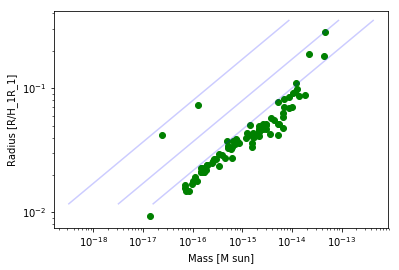

In [64]:
delta = sizeL/n
unitmass = 2e-13 * (delta)**3

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Radius [R/H_1R_1]')
plt.xlabel('Mass [M sun]')

# plt.scatter(delta*dapa[:,1],unitmass*dapa[:,0], c='blue')
# plt.scatter(delta*dapa[:,2],unitmass*dapa[:,0], c='red')
# plt.scatter(delta*dapa[:,3],unitmass*dapa[:,0], c='green')
plt.scatter(unitmass*dapa[:,0],delta*dapa[:,3], c='green')

x = delta*np.linspace(1,30,10)

plt.plot( (2.e-13)*x**3., x, c='blue', alpha=0.2)
plt.plot( (2.e-12)*x**3., x, c='blue', alpha=0.2)
plt.plot( (1.e-11)*x**3., x, c='blue', alpha=0.2)
plt.show()

In [65]:
ecc = []
for i in range(0,len(pain)):
    mix = min(pain[i])
    man = max(pain[i])
    ecc.append((man-mix)/(man+mix))
    # print(mix, man)

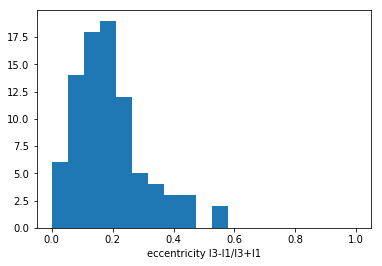

In [66]:
plt.xlabel('eccentricity I3-I1/I3+I1')

plt.hist(ecc,bins=np.linspace(0,1,20))
plt.show()

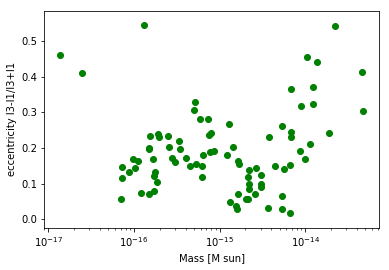

In [67]:
plt.ylabel('eccentricity I3-I1/I3+I1')
plt.xlabel('Mass [M sun]')

plt.xscale('log')
plt.scatter(unitmass*dapa[:,0],ecc, c='green')

plt.show()

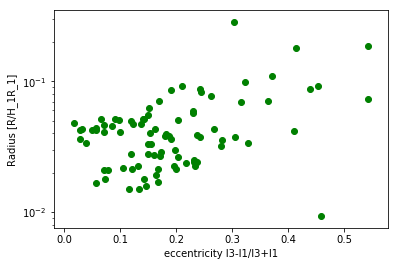

In [68]:
plt.ylabel('Radius [R/H_1R_1]')
plt.xlabel('eccentricity I3-I1/I3+I1')

plt.yscale('log')
plt.scatter(ecc,delta*dapa[:,3], c='green')

plt.show()

# MULTITHRESHOLD?

In [16]:
data_file = '../../data/L3_1536_256(WKB)/out/m/axion.r.00039_2'
file = h5py.File(data_file, 'r')

n = file.attrs[u'Size']
sizeL = file.attrs[u'Physical size']

n2 = n*n
n3 = n2*n

data = file['energy/density'].value.reshape(n3)

In [17]:
thresholdtab = np.array([50,40,30,20,18,15,12,10,8,6,5,4])

In [18]:
apa = []

for dens_th in thresholdtab:

    npo, pos, den = basicstuff(data, dens_th)

    start = time.time()
    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, n_jobs=n_jobs).fit(pos)
    labels = np.array(db.labels_)
    end = time.time()
    #print('clustering Z-shifted took %1.3f s' %(end-start))

    nh = n//2

    # shift coordinates of the grid by n/2 in Z and make mod[256]
    pos2 = (pos + [nh,nh,nh])%n

    #start = time.time()
    db2 = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, n_jobs=n_jobs).fit(pos2)
    labels2 = np.array(db2.labels_)
    end = time.time()
    print('clustering Z-shifted took %1.3f s' %(end-start))

    newlabels, dicta = sex(labels,labels2)
    
    apa.append([dens_th,len(set(newlabels)),end-start])

clustering Z-shifted took 0.005 s
rela2 [-2]
clustering Z-shifted took 0.015 s
rela2 [-2]
clustering Z-shifted took 0.092 s
rela2 [-2]
clustering Z-shifted took 0.441 s
rela2 [48 -2 -1]
48 [48]
clustering Z-shifted took 0.488 s
rela2 [53 -2 -1]
53 [53]
clustering Z-shifted took 0.721 s
rela2 [70 76 77 78 21 -1 -2]
70 [70]
76 [76]
77 [77]
78 [78]
21 [21]
clustering Z-shifted took 1.330 s
rela2 [66 73 -2 -1 30]
66 [66]
73 [73]
30 [30]
clustering Z-shifted took 2.185 s
rela2 [ 64  97 101  71  75  12  13  78  84  -1  91  -2]
64 [64]
97 [97]
101 [101]
71 [71]
75 [75]
12 [12]
13 [13]
78 [78]
84 [84]
91 [91]
clustering Z-shifted took 3.459 s
rela2 [48 -2 -1]
48 [48]
clustering Z-shifted took 7.984 s
rela2 [-2 71]
71 [71]
clustering Z-shifted took 12.933 s
104  ojo  [100   6] in newlabels assotiated to label 6
rela2 [262 263 295  73 205 273 277  86  -1  28  -2]
262 [262]
263 [263]
295 [295]
73 [73]
205 [205]
273 [273]
277 [277]
86 [86]
28 [28]
clustering Z-shifted took 22.260 s
64  ojo  [58 44

In [19]:
apa=np.array(apa)

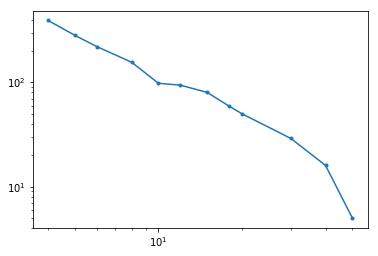

In [20]:
plt.yscale('log')
plt.xscale('log')
plt.plot(apa[:,0],apa[:,1],marker='.')
plt.show()

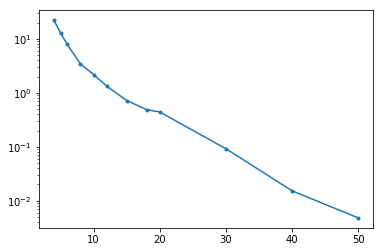

In [21]:
plt.yscale('log')
plt.plot(apa[:,0],apa[:,2],marker='.')
plt.show()